# Description of project

Customer behavior and booking possibilities have been radically changed by online hotel reservation channels. Cancellations or no-shows cause a significant number of hotel reservations to be canceled. Cancellations can be caused by a variety of factors, such as scheduling conflicts, changes in plans, etc. In many cases, this is made easier by the possibility of doing so free or at a low cost, which is beneficial for hotel guests but less desirable and possibly revenue-diminishing for hotels.

**The purpose of case study is:**

As a Data Scientist, your job is to build a Machine Learning model to help the Hotel Owners better understand if the customer is going to honor the reservation or cancel it ?

The dataset was downloaded from:
[Kaggle - Playground Series - Season 3, Episode 7](https://www.kaggle.com/competitions/playground-series-s3e7/overview)

Dataset was prepared into this [Jupyter-notebook](EDA_Datascience10092022_AmadeuszMinta.ipynb)

# Machine learning

## Tools

### Libraries

In [12]:
# Importing needed libraries

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as ss
import itertools

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# pipeline construction
from sklearn.pipeline import make_pipeline, Pipeline

# models training
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Functions

In [55]:
#This function allows to examine a group of classifiers with diverse parameters
def train_model(algo, X_train, y_train, X_test, y_test, param_grid=None):
    steps = [('model', algo)]
    clf = Pipeline(steps=steps)
    
    if param_grid is None:
        model = clf.fit(X_train, y_train)
        b_params = 'Standard settings'
    else:
        clf = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           cv=2) # In accordance with 2.3 subpoint, cross validation is not significant  
        clf.fit(X_train, y_train)
        model = clf.best_estimator_
        b_params = clf.best_params_

    score = model.score(X_test, y_test)
    return model, score, b_params

# This function displays all main results for classifier 
def all_metrics(name, best_estimator, X, y):
    results = [name]
    predictions = best_estimator.predict(X)
    # metrics
    results.append(accuracy_score(y, predictions)) # accuracy
    results.append(recall_score(y, predictions)) # recall
    results.append(precision_score(y, predictions)) # precision
    results.append(f1_score(y, predictions)) # F1
    
    return format_results(results)


def format_results(results):
    print(f'{results[0]:>10s}: Accuracy {results[1]:.3f} | Recall {results[2]:.3f} | Precision {results[3]:.3f} | F1 {results[4]:.3f}')

### Uploading dataset

In [3]:
X = pd.read_csv('X_ml.csv', sep=',')
y = pd.read_csv('y_ml.csv', sep=',')
y = y['booking_status']
print(f'X: {X.shape}, y: {y.shape}')

X: (36050, 51), y: (36050,)


### Split data into training and test set 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set:\nX_train = {X_train.shape}; y_train = {y_train.shape}\nX_test = {X_test.shape}; y_test = {y_test.shape}')

Train set:
X_train = (28840, 51); y_train = (28840,)
X_test = (7210, 51); y_test = (7210,)


**Summary:**

The dataset was divided by Pareto rule, ie. 80/20 percent

## Examining baseline models

### Logistic Regression with default settings - first classification

In [5]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [6]:
lr.score(X_train, y_train)

0.7740984743411928

In [7]:
lr.score(X_test, y_test)

0.7740638002773925

Results are quite close to each other. There is  not see underfitting or overfitting. It is correct.

### Examination of the main classifiers and their evaluation 

In [8]:
# Classifiers from the supervised classification family - supervised learning
classifiers = {
    'LogReg': LogisticRegression(), 
    'NB' : GaussianNB(),
    'kNN' : KNeighborsClassifier(),
    'SVC' : SVC(),
    'Tree' : DecisionTreeClassifier()
}

`Logistic Regression`, `Gaussian Naive Bayes`, `k-nearest neighbors vote` and `C-Support Vector Classification` require to use of a scaler. Because of the variables in my dataset is only binary. So I avoided using any scaler.  

In [9]:
for name, classifier in classifiers.items():
    clf = classifier.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # metrics
    accuracy = accuracy_score(y_test, predictions) # accuracy
    recall = recall_score(y_test, predictions) # recall
    precision = precision_score(y_test, predictions) # precision
    f1 = f1_score(y_test, predictions) # F1
    
    print(f'{name:>6s}: Accuracy {accuracy:.3f} | Recall {recall:.3f} | Precision {precision:.3f} | F1 {f1:.3f}')

LogReg: Accuracy 0.774 | Recall 0.726 | Precision 0.750 | F1 0.738
    NB: Accuracy 0.660 | Recall 0.805 | Precision 0.580 | F1 0.674
   kNN: Accuracy 0.734 | Recall 0.674 | Precision 0.704 | F1 0.689
   SVC: Accuracy 0.783 | Recall 0.736 | Precision 0.761 | F1 0.748
  Tree: Accuracy 0.723 | Recall 0.638 | Precision 0.701 | F1 0.668


**Summary:**

To better evaluate individual classifiers, additional metrics for evaluating classifiers were used, i.e. `recall`, `precision`, and `F1`. Despite these additional metrics, the main evaluation criterion will be `accuracy`

The best results were obtained for two classifiers, i.e. `Logistic Regression` and `SVC`

The best results were obtained for two classifiers, i.e. `Logistic Regression` and `SVC`. Although `SVC` results are slightly better the cost (machine learning time) is too high. Therefore, after the first tests, `Logistic Regression` is the best classifier considering the cost and the results obtained

### Examining baseline models with cross validation 

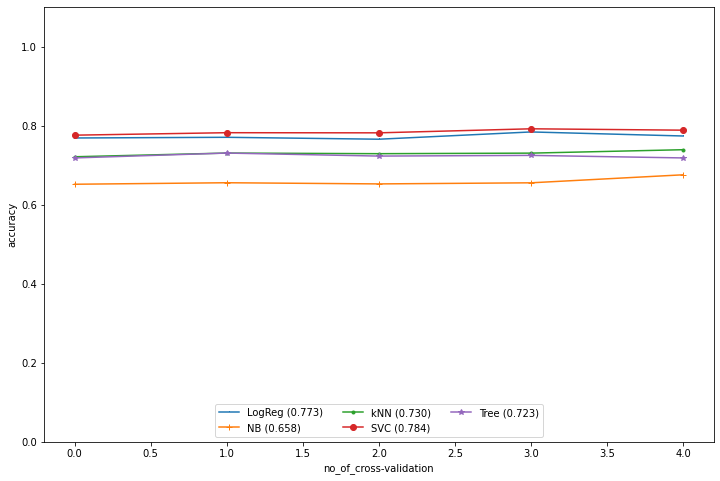

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
markers = itertools.cycle((',', '+', '.', 'o', '*')) 
for name, classifier in classifiers.items():
    cv_scores = cross_val_score(classifier,
                               X_train, y_train,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1 #using all cores 
                               )
    
    my_label = f'{name} ({cv_scores.mean():.3f})'
    ax.plot(cv_scores, marker=next(markers), label=my_label)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('no_of_cross-validation')
    ax.set_ylabel('accuracy')
    ax.legend(ncol=3, loc='lower center')

The results from `the cross-validation` allow us to conclude that the features are balanced and there should be no **overfitting** during classification.

It can be assumed that the binary form of the features is the reason for this 

### GirdSearchCV - finding the best classifier

**Testing classifiers with different hyperparameter settings** 

Setting and selecting the best hyperparameters

In [32]:
algos = {
    "LogReg": {"algo": LogisticRegression(solver='liblinear'), #  It applies automatic parameter selection (a.k.a L1 Regularization) and it’s recommended when you have high dimension dataset (recommended for solving large-scale classification problems)
               "params": {
                            "model__C": [0.1, 10, 100, 10000],
                            "model__fit_intercept": (True, False)
                         }
              },
    "NB": {
            "algo": GaussianNB(), 
            "params": None
          }, 
    "kNN": {
            "algo": KNeighborsClassifier(), 
            "params": {
                        "model__n_neighbors": [3, 5, 10], # number of neighbours to consider
                        "model__metric": ['minkowski', 'cosine'], # how distance is measured
                        "model__p": [1, 2] # in case distance is measured as minkowski, p=1 means Manhattan; p=2 means Euclidean
                      } 
                        
            }, 
    "SVC": {"algo": SVC(kernel='linear'), 
            "params": {
                        "model__C": [0.1, 1, 10] 
#                         "model__gamma": [0.001, 1]
                      }
           }, 
    "Tree": {"algo": DecisionTreeClassifier(criterion='entropy'), 
             "params": {
                        "model__max_depth": [3, 5, 7, 10], # if not specified, the nodes will be expanded until all leaf nodes are pure (have 0 cases of some class)
                        "model__min_samples_split": [2, 5, 10, 15], # minimum samples required to split an internal node (number must be higher for split to happen)
                       }
            }
}

In [33]:
result_dict = {}
for key in algos.keys():
    result = train_model(algos[key]['algo'], 
                         X_train, y_train, X_test, y_test, 
                         algos[key]['params'])
    print(f'{key:>6s}: Accuracy {result[1]:.3f} || Best parameters {result[2]}')
    result_dict[key] = {'best_estimator': result[0], 'score': result[1], 'best_params': result[2]}

LogReg: Accuracy 0.773 || Best parameters {'model__C': 0.1, 'model__fit_intercept': True}
    NB: Accuracy 0.660 || Best parameters Standard settings
   kNN: Accuracy 0.736 || Best parameters {'model__metric': 'cosine', 'model__n_neighbors': 10, 'model__p': 1}
   SVC: Accuracy 0.759 || Best parameters {'model__C': 0.1}
  Tree: Accuracy 0.774 || Best parameters {'model__max_depth': 7, 'model__min_samples_split': 15}


In [34]:
best_model = max(result_dict, key=lambda k: result_dict[k]['score'])
print(f'{best_model:>6s}: {result_dict[best_model]["score"]:.3f}')
print(f'{result_dict[best_model]["best_params"]}')

  Tree: 0.774
{'model__max_depth': 7, 'model__min_samples_split': 15}


**Summary:**

When testing basic classifiers with different parameters, we found that `the decision tree` gave us the best results. However, it requires appropriate parameterization.

I further believe that for the current data set, the best results and at low cost can be obtained for `Logistic Regression`. 

## XGBoost - more advanced classifier

For research purposes, a more advanced classifier was used, i.e. XGBoost

### First using of XGBoost

In [35]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [77]:
all_metrics('XGB_train', XGB, X_train, y_train)
all_metrics('XGB_test', XGB, X_test, y_test)

 XGB_train: Accuracy 0.813 | Recall 0.761 | Precision 0.792 | F1 0.776
  XGB_test: Accuracy 0.778 | Recall 0.728 | Precision 0.755 | F1 0.741


**Summary:**

Regardless of very small overfitting, these results are correct. 

The result of accuracy is similar to the result of `Logistic Regression`

### RandomizedSearchCV and XGBoost

Because of many parameters of `XGBoost Classifier`, the best option is using `RandomizedSearchCV`

In `XGBoost` classes, we found that finding the right parameters with standard methods (`GirdsearchCV`) can be very difficult and time-consuming. Therefore, in this case, `RandomizedSearchCV` was used 

In [39]:
params = {
    'max_depth': ss.randint(3, 50),
    'min_child_weight': ss.randint(3, 15),
    'n_estimators': ss.randint(3, 30),
    'learning_rate': ss.uniform(0.001, 4),
    'gamma': ss.uniform(0.001, 10),
    'reg_lambda': ss.uniform(0.001, 10),
    'reg_alpha': ss.uniform(0.001, 10)
    }
rsCV = RandomizedSearchCV(param_distributions=params,
                        estimator=XGB,
                        n_iter=100,
                        cv=2, # In accordance with 2.3 subpoint, cross validation is not significant  
                        n_jobs=5)
rsCV.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A2F9919C40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A2F905FD90>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A2F991B7F0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A2F9919520>})

In [40]:
rsCV.best_params_

{'gamma': 2.3214768320656343,
 'learning_rate': 0.5556558512282322,
 'max_depth': 38,
 'min_child_weight': 5,
 'n_estimators': 26,
 'reg_alpha': 7.583061388214502,
 'reg_lambda': 4.429152829314591}

In [57]:
all_metrics('XGB_train', rsCV.best_estimator_, X_train, y_train)
all_metrics('XGB_test', rsCV.best_estimator_, X_test, y_test)

 XGB_train: Accuracy 0.791 | Recall 0.736 | Precision 0.764 | F1 0.750
  XGB_test: Accuracy 0.781 | Recall 0.731 | Precision 0.759 | F1 0.745


**Summary:**

The results are close to those with basic `XGBoost`. 

From my point of view, using `Logistic Regression` is the best classifier

## Random Forest Classifier - the most important features 

`RandomForestClassifier` allows you to determine the most important features that the most matter during classification

In [59]:
random_forest = RandomForestClassifier() # Examining with default settings
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
feature_imp = random_forest.feature_importances_
df = pd.concat([pd.Series(random_forest.feature_names_in_), pd.Series(feature_imp)], axis=1)
df.rename(columns={0: 'Features', 1: 'Feature_importances'}, inplace=True)
df.sort_values(by=['Feature_importances'] , ascending=False)

,Features,Feature_importances
2,no_of_special_requests,0.146195
42,market_segment_type_1,0.063713
19,lead_time_0,0.047411
41,market_segment_type_0,0.035963
23,lead_time_4,0.032990
1,type_of_meal_plan,0.031801
20,lead_time_1,0.028621
11,no_of_week_nights_2,0.027760
6,no_of_weekend_nights_0,0.027006
12,no_of_week_nights_3,0.026948


In [75]:
columns = [col for col in df[df['Feature_importances'] > 0.01]['Features']]

The `Feature_importances` parameter was tested for different values. The result obtained was always the same, i.e. the decomposition of variables did not yield noticeably better results 

In [76]:
columns

['no_of_children',
 'type_of_meal_plan',
 'no_of_special_requests',
 'no_of_adults_1',
 'no_of_adults_2',
 'no_of_weekend_nights_0',
 'no_of_weekend_nights_1',
 'no_of_weekend_nights_2',
 'no_of_week_nights_0',
 'no_of_week_nights_1',
 'no_of_week_nights_2',
 'no_of_week_nights_3',
 'no_of_week_nights_4',
 'no_of_week_nights_5',
 'room_type_reserved_0',
 'room_type_reserved_1',
 'lead_time_0',
 'lead_time_1',
 'lead_time_2',
 'lead_time_3',
 'lead_time_4',
 'lead_time_5',
 'lead_time_6',
 'arrival_month_3',
 'arrival_month_4',
 'arrival_month_5',
 'arrival_month_6',
 'arrival_month_7',
 'arrival_month_8',
 'arrival_month_9',
 'arrival_month_10',
 'arrival_month_11',
 'arrival_month_12',
 'market_segment_type_0',
 'market_segment_type_1',
 'avg_price_per_room_1',
 'avg_price_per_room_2']

Examining baseline models with default settings for classifiers from 2.2 subpoint but **limited features**

In [72]:
for name, classifier in classifiers.items():
    clf = classifier.fit(X_train[columns], y_train)
    predictions = clf.predict(X_test[columns])
    # metrics
    accuracy = accuracy_score(y_test, predictions) # accuracy
    recall = recall_score(y_test, predictions) # recall
    precision = precision_score(y_test, predictions) # precision
    f1 = f1_score(y_test, predictions) # F1
    
    print(f'{name:>6s}: Accuracy {accuracy:.3f} | Recall {recall:.3f} | Precision {precision:.3f} | F1 {f1:.3f}')

LogReg: Accuracy 0.756 | Recall 0.691 | Precision 0.735 | F1 0.712
    NB: Accuracy 0.689 | Recall 0.595 | Precision 0.660 | F1 0.626
   kNN: Accuracy 0.725 | Recall 0.658 | Precision 0.696 | F1 0.676
   SVC: Accuracy 0.764 | Recall 0.677 | Precision 0.757 | F1 0.715
  Tree: Accuracy 0.755 | Recall 0.683 | Precision 0.738 | F1 0.710


Previous results regarding to 2.2 subpoint with all features

* **LogReg**: Accuracy `0.774` | Recall `0.726` | Precision `0.750` | F1 `0.738`
* **NB**: Accuracy `0.660` | Recall `0.805` | Precision 0.580 | F1 `0.674`    
* **kNN**: Accuracy `0.734` | Recall `0.674` | Precision 0.704 | F1 `0.689`  
* **SVC**: Accuracy `0.783` | Recall `0.736` | Precision 0.761 | F1 `0.748`
* **Tree**: Accuracy `0.723` | Recall `0.638` | Precision 0.701 | F1 `0.668`

**Summary:**

This technique of reducing features did not improve the results of baseline models. 

A better result is only noticed for `Naive Bayes`. 

It can suppose that this method in this case is not essential. 

Because of these results, I resigned from using `PCA` (`Principal component analysis`)

## Conclusion 

* The best results were obtained for `XGBoost`. However, taking into account its large number of parameters and its complexity, the best solution for the classification process in question (cancellation of hotel accommodation) is `Logistic Regression` from my point of view. 
* The `SVC` classifier also gives satisfactory results. Even with standard settings. Unfortunately, its cost is too high and makes the process of parameter adjustment difficult.
* `Cross-validation` for the current data set does not have much impact on model's accuracy. Mainly, the choice of the right model affects the results. It is likely that further work on `hyperparameter` adjustment could yield better results.
